# Benchmark SXPR

In this notebook, we will benchmark a 16-layer Resnet model. There are quite some hyperparameters we tried on. All benchmark below are done with bottleneck layer at width 40 for simplicity.


In [1]:
# ============== Click Please.Imports
import sys
import glob
import gc


import random
random.seed(42)
import pandas as pd

import torch
import seaborn as sns

import matplotlib.pyplot as plt



import tqdm



# ================
# Torch related
# ==============
import torch 
from torch import nn



import pytorch_lightning as pl
import torchmetrics

# Turn on cuda optimizer
print(torch.backends.cudnn.is_available())
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
# disable debugs NOTE use only after debugging
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
# Disable gradient tracking
torch.no_grad()


# =============
# NN
# =================
sys.path.append('../')
from NucleicNet.DatasetBuilding.util import *
from NucleicNet.DatasetBuilding.commandReadPdbFtp import ReadBCExternalSymmetry, MakeBcClanGraph
from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset
from NucleicNet.DatasetBuilding.commandBenchmark import BenchmarkWrapper
from NucleicNet import Burn, Fuel
import NucleicNet.Burn.M1
import NucleicNet.Burn.util





%config InlineBackend.figure_format = 'svg'

sns.set_context("notebook")




True


# Benchmarking a 16-layers Resnet

The following section is a 3 fold cross-validation of all members of the clan. It will report `UserWarning: 4 nan values found in confusion matrix have been replaced with zeros` when some classes are missing (e.g. in this case one class is missing in the structure).  In some cases, the cuda asynchronization seems to be problematic and complaining out of memory problem, but nevertheless very few instances occurred and not the whole clan reporting the problem. No panic. Several performance metrics are evaluated along the way

* Top1 accuracy/precision/recall (macro/micro/class-weighted)
* Top2 accuracy/precision/recall (macro/micro/class-weighted)
* Confusion matrix

The dataframe containing the performance is pickled at `../Benchmark/DfBenchmark__*.pkl`. It will take 1-2 hours to complete the benchmarking.



In [ ]:
BenchmarkWrapperC = BenchmarkWrapper(   DIR_Benchmark = '../Benchmark/',
                                        DIR_Models = "../Models/",
                                        OutputKeyword = "SXPR-9CV",
                                        Checkpointlist = [
                                            
                                            # NOTE depth 16 
                                            "../Models/SXPR-9CV_SXPR-9CV/132_133/checkpoints/epoch=2-step=51700-hp_metric=0.5486971139907837.ckpt",
                                            "../Models/SXPR-9CV_SXPR-9CV/134_135/checkpoints/epoch=2-step=51473-hp_metric=0.5440343022346497.ckpt",
                                            "../Models/SXPR-9CV_SXPR-9CV/136_137/checkpoints/epoch=2-step=52381-hp_metric=0.4679257273674011.ckpt",

                                        ],
                                        DIR_DerivedData = '../Database-PDB/DerivedData/',
                                        n_CrossFold = 9, ClanGraphBcPercent = 90, # TODO Put into haram?
                                        User_Task = "SXPR", 
                                        User_SxprDatastride = 1,
                                        )
grandbenchmark_df_16 = BenchmarkWrapperC.Run()

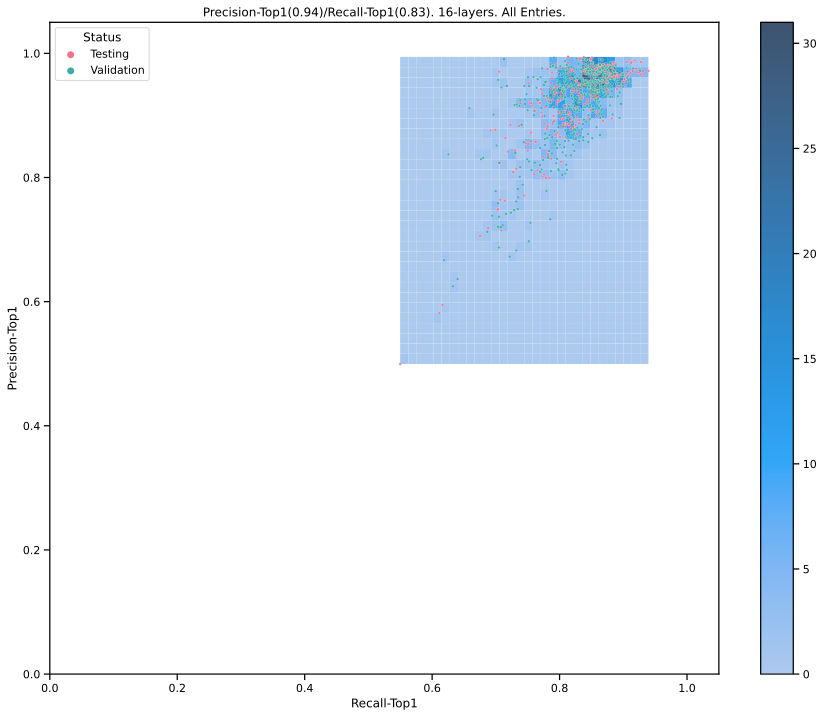

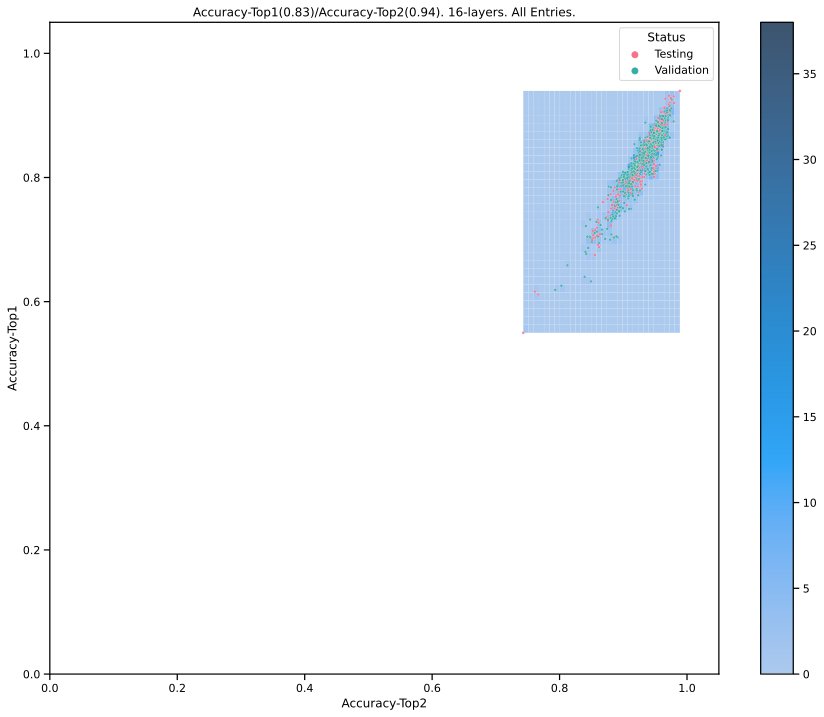

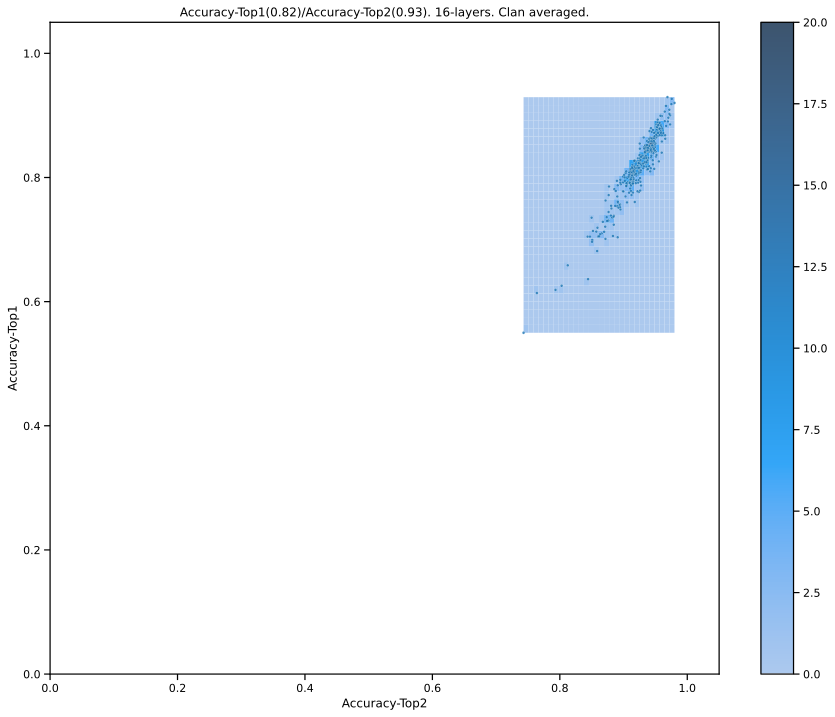

In [3]:
# NOTE This inspect on the weakness of the model
Weak_Training = grandbenchmark_df_16.loc[(grandbenchmark_df_16['Accuracy-Top1'] < 0.5)][['Pdbid','Accuracy-Top1' ]]



# ===============================
# Plot all
# ===============================
plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_16, y="Precision-Top1", x="Recall-Top1", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_16, y="Precision-Top1", x="Recall-Top1", 
                marker = 'o', s = 8.0, hue = 'Status', palette='husl', alpha = 0.8)

plt.title("Precision-Top1(%.2f)/Recall-Top1(%.2f). 16-layers. All Entries." %(grandbenchmark_df_16["Precision-Top1"].median(),grandbenchmark_df_16["Recall-Top1"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_16, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_16, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, hue = 'Status', palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). 16-layers. All Entries." %(grandbenchmark_df_16["Accuracy-Top1"].median(),grandbenchmark_df_16["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_16_ClanGrouped = grandbenchmark_df_16.groupby(by=["Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_16_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_16_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). 16-layers. Clan averaged." %(grandbenchmark_df_16_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_16_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()


#print(Weak_Testing)

# Epilogue

Note that the Clan-averaged Top-1 accuracy ~0.71 stated in our paper is understated due to the use of data stride. Here, with the efficient use of pytorch dataloader we can go through all the data without stride and it reveals an accuracy ~0.82 taking account of all available data. Try `User_SxprDatastride = 6` will produce similar datapoint ratio and accuracy ~0.73 as in the paper. The reason why there is a drop in accuracy is that when stride is taken it will retrieve more halo grid points from the outer layer of volume than the inner layer (think about a sphere.), where those points tend to have less content in the Altman vectors. This applies particularly well for large proteins where a lot of non-sites are present on the surface. A further remark here is that during training a datastride of 30 was used to speed up the process, however, a smaller datastride should also be attempted when resource allows.

Don't forget to test AUCG!